# Определение перспективного тарифа для телеком компании

**Данные** - <em>данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год</em><br>
**Цель** - <em>сделать предварительный анализ тарифов на небольшой выборке клиентов.</em><br>  Нужно проанализировать поведение клиентов и сделать вывод — какой тарифный план приносит больше доход компании.

**Описание данных**

<em>Таблица users (информация о пользователях):</em>
-	user_id — уникальный идентификатор пользователя
-	first_name — имя пользователя
-	last_name — фамилия пользователя
-	age — возраст пользователя (годы)
-	reg_date — дата подключения тарифа (день, месяц, год)
-	churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
-	city — город проживания пользователя
-	tariff — название тарифного плана

<em>Таблица calls (информация о звонках):</em>
-	id — уникальный номер звонка
-	call_date — дата звонка
-	duration — длительность звонка в минутах
-	user_id — идентификатор пользователя, сделавшего звонок

<em>Таблица messages (информация о сообщениях):</em>
-	id — уникальный номер сообщения
-	message_date — дата сообщения
-	user_id — идентификатор пользователя, отправившего сообщение

<em>Таблица internet (информация об интернет-сессиях):</em>
-	id — уникальный номер сессии
-	mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
-	session_date — дата интернет-сессии
-	user_id — идентификатор пользователя

<em>Таблица tariffs (информация о тарифах):</em>
-	tariff_name — название тарифа
-	rub_monthly_fee — ежемесячная абонентская плата в рублях
-	minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
-	messages_included — количество сообщений в месяц, включённых в абонентскую плату
-	mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
-	rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
-	rub_per_message — стоимость отправки сообщения сверх тарифного пакета
-	rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Оглавление
1. [Загрузка данных и изучение общей информации по проекту](#download-data)
2. [Предобработка данных](#data-preprocessing)
    - [Обработка пустых значений](#processing-empty-values)
    - [Замена типа данных](#data-type-change)
3. [Расчет данных и добавление их в сводную таблицу](#data-counting)
    - [Подсчет количества сделанных звонков и израсходованных минут разговора по месяцам](#сount-calls-number)
    - [Подсчет количества отправленных сообщений по месяцам](#count-sent-messages)
    - [Подсчет объема израсходованного интернет-трафика по месяцам](#count-internet-volume)
    - [Подсчет помесячной выручки с каждого пользователя](#count-monthly-revenue-per-user)
4. [Анализ данных](#data-analysis)
5. [Проверка гипотез](#hypothesis-testing)
    - [Проверяем гипотезу о различии средней выручки пользователей по тарифам «Ультра» и «Смарт»](#revenue-difference-UltravsSmart) 
    - [Проверяем гипотезу о различии средней выручки пользователей из Москвы от выручки пользователей из других регионов](#revenue-difference-Moscowvsregions)
6. [Выводы](#conclusions)

## <a id='download-data'><span style="color:black">1. Загрузка данных и изучение общей информации по проекту</span></a>

In [1]:
from matplotlib.ticker import FuncFormatter
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats as st
warnings.filterwarnings("ignore")
# для более удобной работы со таблицами мы уберем ограничение строк и столбцов в отображении
pd.options.display.max_columns = None

In [2]:
def load_data(table, description, index=None):
    data = pd.read_csv(f'datasets/{table}.csv', index_col=index)
    print('==========================================')
    print(f'Таблица {table} ({description})')
    print('==========================================')
    display(data.head(10))
    print('========================================================')
    print(f'Общая информация по датафрейму {table} и всем признакам')
    print('========================================================')
    display(data.info(memory_usage='deep'))
    return(data)

users = load_data('users', 'информация о пользователях')

Таблица users (информация о пользователях)


user_id  age churn_date              city first_name  last_name  \
0     1000   52        NaN         Краснодар     Рафаил  Верещагин   
1     1001   41        NaN            Москва       Иван       Ежов   
2     1002   59        NaN       Стерлитамак    Евгений  Абрамович   
3     1003   23        NaN            Москва      Белла   Белякова   
4     1004   68        NaN       Новокузнецк    Татьяна   Авдеенко   
5     1005   67        NaN  Набережные Челны   Афанасий     Горлов   
6     1006   21        NaN         Ульяновск     Леонид   Ермолаев   
7     1007   65        NaN            Москва        Юна   Березина   
8     1008   63        NaN         Челябинск     Рустэм  Пономарёв   
9     1009   24        NaN             Пермь   Василиса    Блинова   

     reg_date tariff  
0  2018-05-25  ultra  
1  2018-11-01  smart  
2  2018-06-17  smart  
3  2018-08-17  ultra  
4  2018-05-14  ultra  
5  2018-01-25  smart  
6  2018-02-26  smart  
7  2018-04-19  smart  
8  2018-12-19  smart  
9  2018-03-22  smart

Общая информация по датафрейму users и всем признакам
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 229.6 KB


None

Таблица с информацией о пользователей состоит из 500 записей и 8 признаков. Обращает на себя внимание следующие моменты: в столбце "churn_date" имеются пустые значения (что предусмотрено условиями), а также в столбце "reg_date" необходимо помянять тип данных на datetime.

In [3]:
calls = load_data('calls', 'информация о звонках')

Таблица calls (информация о звонках)


id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000
5  1000_5  2018-11-02      0.00     1000
6  1000_6  2018-10-18      0.00     1000
7  1000_7  2018-08-22     18.31     1000
8  1000_8  2018-09-15     18.44     1000
9  1000_9  2018-08-15      0.00     1000

Общая информация по датафрейму calls и всем признакам
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 28.6 MB


None

Таблица с информацией о звонках состоит из 206607 записей и 4 признаков. В столбце "call_date" необходимо помянять тип данных на datetime, в столбце "duration" нужно округлить вверх значения минут, т.к. у компании "Мегалайн" поминутная тарификация.

In [4]:
messages = load_data('messages', 'информация о сообщениях')

Таблица messages (информация о сообщениях)


id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000
5  1000_5   2018-06-20     1000
6  1000_6   2018-11-19     1000
7  1000_7   2018-10-29     1000
8  1000_8   2018-06-25     1000
9  1000_9   2018-12-18     1000

Общая информация по датафрейму messages и всем признакам
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 16.4 MB


None

Таблица с информацией о сообщениях состоит из 123036 записей и 3 признаков. В столбце "message_date" необходимо помянять тип данных на datetime.

In [5]:
internet = load_data('internet', 'информация об интернет-сессиях', 'Unnamed: 0')

Таблица internet (информация об интернет-сессиях)


id  mb_used session_date  user_id
0  1000_0   112.95   2018-11-25     1000
1  1000_1  1052.81   2018-09-07     1000
2  1000_2  1197.26   2018-06-25     1000
3  1000_3   550.27   2018-08-22     1000
4  1000_4   302.56   2018-09-24     1000
5  1000_5   399.97   2018-10-02     1000
6  1000_6   540.08   2018-09-07     1000
7  1000_7   415.70   2018-07-11     1000
8  1000_8   505.40   2018-10-08     1000
9  1000_9   345.54   2018-09-03     1000

Общая информация по датафрейму internet и всем признакам
<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 22.2 MB


None

Таблица с информацией об интернет-сессиях состоит из 149396 записей и 4 признаков. В столбце "session_date" необходимо помянять тип данных на datetime, в столбце "mb_used" нужно округлить вверх значения мегабайт, т.к. у компании "Мегалайн" помегабайтная тарификация.

In [6]:
tariffs = load_data('tariffs', 'информация о тарифах')

Таблица tariffs (информация о тарифах)


messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3               3       smart  
1             1950         150                1               1       ultra

Общая информация по датафрейму tariffs и всем признакам
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 364.0 bytes


None

Таблица с информацией о тарифах состоит из 2 записей и 8 признаков.

**Вывод:** Изучение данных позволило выявить ряд недостатков и аномалий, которые необходимо устранить до перехода к анализу.

## <a id='data-preprocessing'><span style="color:black">2. Предобработка данных</span></a>

### <a id='processing-empty-values'><span style="color:black">Обработка пустых значений</span></a>

В столбце churn_date таблицы users имеются пропущенные значения. Нужно определить причины, по которым появились пропуски, как наличие пропусков влияет на дальнейший анализ данных, каким образом обработать пропущенные значения.

In [7]:
display(users.sample(10))
display(users[users['churn_date'].isnull() == False].sample(10))
display(users['churn_date'].info())

user_id  age  churn_date             city first_name last_name  \
216     1216   74         NaN        Волгоград     Рустам   Малинин   
278     1278   46         NaN      Новокузнецк     Леонид  Троицкий   
21      1021   61         NaN        Краснодар  Святослав   Тихонов   
30      1030   28         NaN        Махачкала   Мариетта  Русанова   
466     1466   37         NaN      Новосибирск      Рубен    Шевцов   
390     1390   56         NaN  Санкт-Петербург      Лидия   Беляева   
114     1114   53         NaN            Пермь  Маргарита  Колесова   
19      1019   63  2018-10-05            Томск    Игнатий   Круглов   
305     1305   37         NaN           Москва     Эмилия   Лаптева   
215     1215   55         NaN           Рязань     Руслан     Алиев   

       reg_date tariff  
216  2018-11-23  smart  
278  2018-12-23  smart  
21   2018-04-26  ultra  
30   2018-05-23  smart  
466  2018-02-28  ultra  
390  2018-07-30  smart  
114  2018-07-26  smart  
19   2018-05-16  ultra  
305  2018-10-25  smart  
215  2018-08-12  smart

user_id  age  churn_date              city first_name   last_name  \
71      1071   20  2018-08-31              Омск     Гектор     Чумаков   
191     1191   64  2018-10-03  Набережные Челны  Александр   Акиндинов   
353     1353   57  2018-11-26   Санкт-Петербург   Доминика    Анищенко   
371     1371   50  2018-12-30              Омск     Ириней    Трофимов   
64      1064   55  2018-12-26            Якутск     Динара     Алфеева   
163     1163   21  2018-12-16            Москва        Лев  Вишневский   
242     1242   39  2018-12-21         Хабаровск      Радим    Федосеев   
343     1343   30  2018-10-28          Кострома      Анита  Верещагина   
422     1422   60  2018-12-21            Москва      Клара    Устинова   
128     1128   51  2018-12-23          Волжский     Ксения      Агаева   

       reg_date tariff  
71   2018-01-09  smart  
191  2018-06-30  smart  
353  2018-04-22  smart  
371  2018-12-25  smart  
64   2018-03-17  smart  
163  2018-11-03  smart  
242  2018-11-18  smart  
343  2018-08-15  ultra  
422  2018-10-12  smart  
128  2018-12-15  ultra

<class 'pandas.core.series.Series'>
RangeIndex: 500 entries, 0 to 499
Series name: churn_date
Non-Null Count  Dtype 
--------------  ----- 
38 non-null     object
dtypes: object(1)
memory usage: 4.0+ KB


None

В таблице users столбце "churn_date" содержит даты прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных), таким образом пустые значения в столбце "churn_date" удалять не нужно, но можно рассмотреть вопрос о том, как использовать данные о прекращении пользования тарифом.

Каждый пользователь имеет свой индификационный номер, поэтому столбцы first_name и last_name можно удалить (такая информация для целей настоящего проекта избыточна), что позволит использовать меньше памяти.

In [8]:
users = users.drop(['first_name', 'last_name'], axis=1) 
display(users.head())

user_id  age churn_date         city    reg_date tariff
0     1000   52        NaN    Краснодар  2018-05-25  ultra
1     1001   41        NaN       Москва  2018-11-01  smart
2     1002   59        NaN  Стерлитамак  2018-06-17  smart
3     1003   23        NaN       Москва  2018-08-17  ultra
4     1004   68        NaN  Новокузнецк  2018-05-14  ultra

In [9]:
display(calls.head())

id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000

Столбец duration таблицы calls содержит нулевые значения.

In [10]:
display(calls.duration.count())
print(calls[calls["duration"] == 0.0]["duration"].value_counts()[0])

202607

39613


В столбце duration таблицы calls 39613 нулевых значений из 202607 общего количества переменных в столбце. Такие значения могли появиться когда пользователь не дозванился и происходит соединение с голосовой почтой (или без такого соединения). Заполнять такие значения не нужно, так как переменная в дальнейшем будет применена при расчете выручки. Удалять такие значения тоже не нужно, так как переменная будет учитываться при подсчете активности пользователей (количество совершенных звонков).

In [11]:
tables = [users, calls, messages, internet]
for table in tables:
    duplicates = table.duplicated().sum()

if duplicates > 0:
    print(f'Количество дубликатов в таблицах: {table.duplicated().sum()}')
else:
    print('Дубликаты в таблицах не обнаружены')


Дубликаты в таблицах не обнаружены


### <a id='data-type-change'><span style="color:black">Замена типа данных</span></a>

Заменим тип данных на datetime ранее определенных столбцов.

In [12]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y/%m/%d")
display(users['reg_date'].info())
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y/%m/%d")
display(calls['call_date'].info())
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y/%m/%d")
display(messages['message_date'].info())
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y/%m/%d")
display(internet['session_date'].info())

<class 'pandas.core.series.Series'>
RangeIndex: 500 entries, 0 to 499
Series name: reg_date
Non-Null Count  Dtype         
--------------  -----         
500 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 4.0 KB


None

<class 'pandas.core.series.Series'>
RangeIndex: 202607 entries, 0 to 202606
Series name: call_date
Non-Null Count   Dtype         
--------------   -----         
202607 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.5 MB


None

<class 'pandas.core.series.Series'>
RangeIndex: 123036 entries, 0 to 123035
Series name: message_date
Non-Null Count   Dtype         
--------------   -----         
123036 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 961.3 KB


None

<class 'pandas.core.series.Series'>
Int64Index: 149396 entries, 0 to 149395
Series name: session_date
Non-Null Count   Dtype         
--------------   -----         
149396 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.3 MB


None

**Выводы:** 
- В полученной выборке данных имелись пропущенных значения, которые не влияют на дальнейший анализ. 
- Принято решение не обрабатывать нулевые значения, которые будут применены в дальнейшем при анализе данных. 
- Дубликаты в таблицах не обнаружены.
- В целом данные сформированы качественно, аномалий не имееют, разбиты на несколько таблиц с ключами, что позволяет использовать меньший объем памяти.

## <a id='data-counting'><span style="color:black">3. Расчет данных и добавление их в сводную таблицу.</span></a>

### <a id='сount-calls-number'><span style="color:black">Подсчет количества сделанных звонков и израсходованных минут разговора по месяцам.</span></a>

In [13]:
calls['duration'] = calls['duration'].apply(np.ceil)
calls['duration'] = calls['duration'].astype('int8')
display(calls.head())

id  call_date  duration  user_id
0  1000_0 2018-07-25         0     1000
1  1000_1 2018-08-17         0     1000
2  1000_2 2018-06-11         3     1000
3  1000_3 2018-09-21        14     1000
4  1000_4 2018-12-15         6     1000

In [14]:
calls_pivot = calls.pivot_table(index=['user_id', calls.call_date.dt.month], values=['duration'], aggfunc=['count', 'sum'])
calls_pivot.columns = ['call_amount', 'total_duration']
calls_pivot.index.names = ['user_id', 'month']
# calls_pivot = calls_pivot.reset_index()
display(calls_pivot.head())

call_amount  total_duration
user_id month                             
1000    5               22           159.0
        6               43           172.0
        7               47           340.0
        8               52           408.0
        9               58           466.0

### <a id='count-sent-messages'><span style="color:black">Подсчет количества отправленных сообщений по месяцам.</span></a>

In [15]:
messages_pivot = messages.pivot_table(index=['user_id', messages.message_date.dt.month], values=['message_date'], aggfunc=['count'])
messages_pivot.columns = ['messages_amount']
messages_pivot.index.names = ['user_id', 'month']
# messages_pivot = messages_pivot.reset_index()
display(messages_pivot.head())

messages_amount
user_id month                 
1000    5                   22
        6                   60
        7                   75
        8                   81
        9                   57

### <a id='count-internet-volume'><span style="color:black">Подсчет объема израсходованного интернет-трафика по месяцам.</span></a>

In [16]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet['mb_used'] = internet['mb_used'].astype('int16')
display(internet.head())

id  mb_used session_date  user_id
0  1000_0      113   2018-11-25     1000
1  1000_1     1053   2018-09-07     1000
2  1000_2     1198   2018-06-25     1000
3  1000_3      551   2018-08-22     1000
4  1000_4      303   2018-09-24     1000

In [17]:
internet_pivot = internet.pivot_table(index=['user_id', internet.session_date.dt.month], values=['mb_used'], aggfunc=['sum'])
internet_pivot.columns = ['mb_amount']
internet_pivot.index.names = ['user_id', 'month']
display(internet_pivot.head())

mb_amount
user_id month           
1000    5         2256.0
        6        23257.0
        7        14016.0
        8        14070.0
        9        14581.0

### <a id='count-monthly-revenue-per-user'><span style="color:black">Подсчет помесячной выручки с каждого пользователя.</span></a>

In [18]:
user_tariff = users[['user_id', 'tariff', 'city']]
user_tariff.rename(columns = {'tariff': 'tariff_name'}, inplace = True )

summary_table = calls_pivot.merge(messages_pivot, 'left', on = ["user_id", "month"]) \
    .merge(internet_pivot, 'left', on = ["user_id", "month"]) \
    .merge(user_tariff, 'left', on = "user_id")

display(summary_table)
display(summary_table.info())

user_id  call_amount  total_duration  messages_amount  mb_amount  \
0        1000           22           159.0             22.0     2256.0   
1        1000           43           172.0             60.0    23257.0   
2        1000           47           340.0             75.0    14016.0   
3        1000           52           408.0             81.0    14070.0   
4        1000           58           466.0             57.0    14581.0   
...       ...          ...             ...              ...        ...   
3169     1498           41           247.0             42.0    20604.0   
3170     1499            9            70.0             11.0     1848.0   
3171     1499           68           449.0             48.0    17809.0   
3172     1499           74           612.0             59.0    17984.0   
3173     1499           69           492.0             66.0    13077.0   

     tariff_name         city  
0          ultra    Краснодар  
1          ultra    Краснодар  
2          ultra    Краснодар  
3          ultra    Краснодар  
4          ultra    Краснодар  
...          ...          ...  
3169       smart  Владикавказ  
3170       smart        Пермь  
3171       smart        Пермь  
3172       smart        Пермь  
3173       smart        Пермь  

[3174 rows x 7 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3173
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          3174 non-null   int64  
 1   call_amount      3174 non-null   int64  
 2   total_duration   3174 non-null   float64
 3   messages_amount  2678 non-null   float64
 4   mb_amount        3163 non-null   float64
 5   tariff_name      3174 non-null   object 
 6   city             3174 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 198.4+ KB


None

In [19]:
summary_table.fillna(0, inplace=True)
display(summary_table.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3173
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          3174 non-null   int64  
 1   call_amount      3174 non-null   int64  
 2   total_duration   3174 non-null   float64
 3   messages_amount  3174 non-null   float64
 4   mb_amount        3174 non-null   float64
 5   tariff_name      3174 non-null   object 
 6   city             3174 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 198.4+ KB


None

In [20]:
temporary_table = summary_table.merge(tariffs, how='left', on ="tariff_name")
temporary_table.head(5)

user_id  call_amount  total_duration  messages_amount  mb_amount  \
0     1000           22           159.0             22.0     2256.0   
1     1000           43           172.0             60.0    23257.0   
2     1000           47           340.0             75.0    14016.0   
3     1000           52           408.0             81.0    14070.0   
4     1000           58           466.0             57.0    14581.0   

  tariff_name       city  messages_included  mb_per_month_included  \
0       ultra  Краснодар               1000                  30720   
1       ultra  Краснодар               1000                  30720   
2       ultra  Краснодар               1000                  30720   
3       ultra  Краснодар               1000                  30720   
4       ultra  Краснодар               1000                  30720   

   minutes_included  rub_monthly_fee  rub_per_gb  rub_per_message  \
0              3000             1950         150                1   
1              3000             1950         150                1   
2              3000             1950         150                1   
3              3000             1950         150                1   
4              3000             1950         150                1   

   rub_per_minute  
0               1  
1               1  
2               1  
3               1  
4               1

In [21]:
def calculation(line):
    
    call_overlimit = line['total_duration'] - line['minutes_included']
    if call_overlimit < 0:
        call_overlimit = 0
    messages_overlimit = line['messages_amount'] - line['messages_included']
    if messages_overlimit < 0:
        messages_overlimit = 0
    mb_overlimit = line['mb_amount'] - line['mb_per_month_included'] 
    if mb_overlimit < 0:
        mb_overlimit = 0
    income = line['rub_monthly_fee'] + call_overlimit * line['rub_per_minute'] \
        + messages_overlimit * line['rub_per_message'] \
        + mb_overlimit / 1024 * line['rub_per_gb']
    return round(income, 2)    
    

summary_table['income'] = temporary_table.apply(calculation, axis=1)
display(summary_table.sample(10))

user_id  call_amount  total_duration  messages_amount  mb_amount  \
1384     1219           76           508.0              6.0    21678.0   
3103     1485           94           584.0            155.0    23447.0   
866      1142           67           475.0             24.0    22350.0   
265      1043           57           403.0              9.0    18005.0   
1048     1168          142          1053.0             42.0    31927.0   
2282     1366           28           223.0             41.0    11966.0   
2820     1442            9            83.0              0.0    14750.0   
2267     1363          133           988.0              0.0    19055.0   
1809     1290           83           643.0              0.0    19004.0   
2366     1377          178          1401.0             10.0     4887.0   

     tariff_name             city   income  
1384       smart            Киров  1807.98  
3103       ultra            Киров  1950.00  
866        smart      Новосибирск  1915.23  
265        smart       Ставрополь  1066.60  
1048       ultra         Кострома  2126.81  
2282       smart  Санкт-Петербург   550.00  
2820       ultra        Ульяновск  1950.00  
2267       ultra     Нижний Тагил  1950.00  
1809       smart  Нижний Новгород  1690.72  
2366       ultra           Брянск  1950.00

**Выводы:** Использование сводных таблиц (группировки данных) и их объединение позволяет получать дополнительные расчетные данные без объединения исходных данных в большой датафрейм, работа с которым потребовала бы значительное потребление памяти.

## <a id='data-analysis'><span style="color:black">4. Анализ данных.</span></a>

In [22]:
ultra = summary_table[summary_table['tariff_name'] == 'ultra']
smart = summary_table[summary_table['tariff_name'] == 'smart']

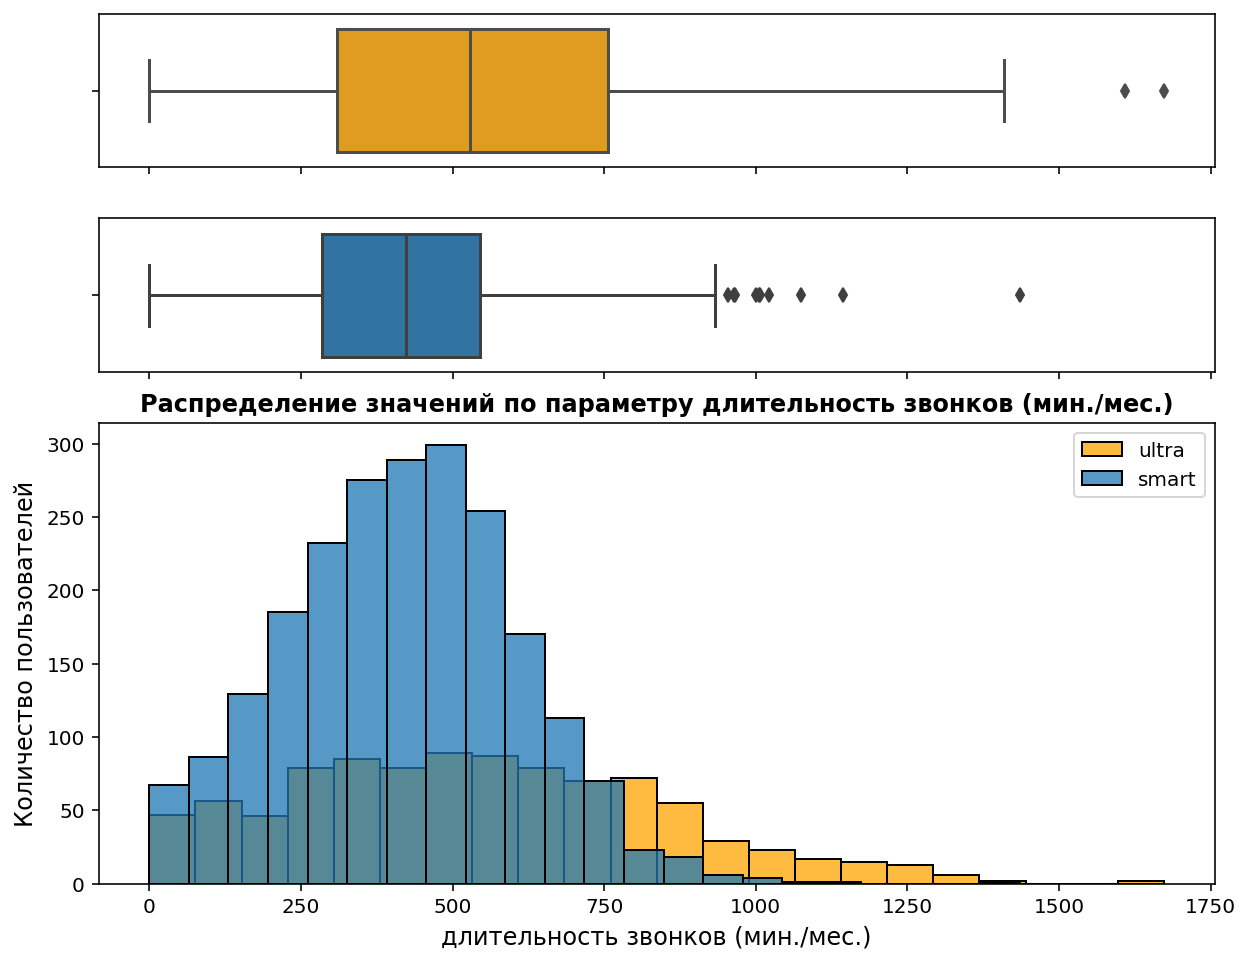

Среднее значение параметра длительность звонков (мин./мес.):
тариф "Ультра" : 545.45
тариф "Смарт" : 419.06
_______________________________________________________________________
Значение дисперсии параметра длительность звонков (мин./мес.):
тариф "Ультра" : 94203.42
тариф "Смарт" : 35844.19
_______________________________________________________________________
Значение стандартного отклонения параметра длительность звонков (мин./мес.):
тариф "Ультра" : 306.93
тариф "Смарт" : 189.33
_______________________________________________________________________


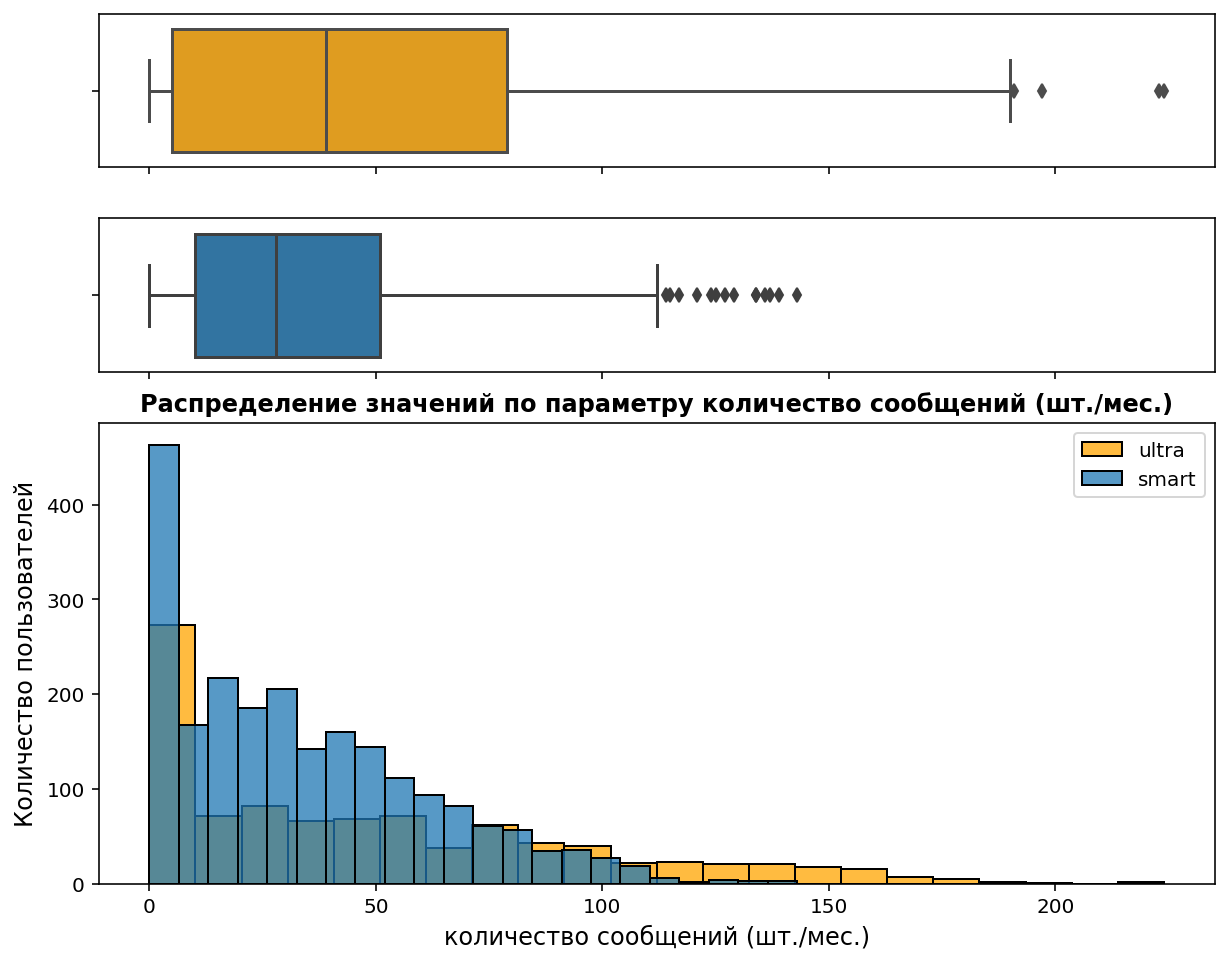

Среднее значение параметра количество сообщений (шт./мес.):
тариф "Ультра" : 49.03
тариф "Смарт" : 33.4
_______________________________________________________________________
Значение дисперсии параметра количество сообщений (шт./мес.):
тариф "Ультра" : 2198.73
тариф "Смарт" : 798.6
_______________________________________________________________________
Значение стандартного отклонения параметра количество сообщений (шт./мес.):
тариф "Ультра" : 46.89
тариф "Смарт" : 28.26
_______________________________________________________________________


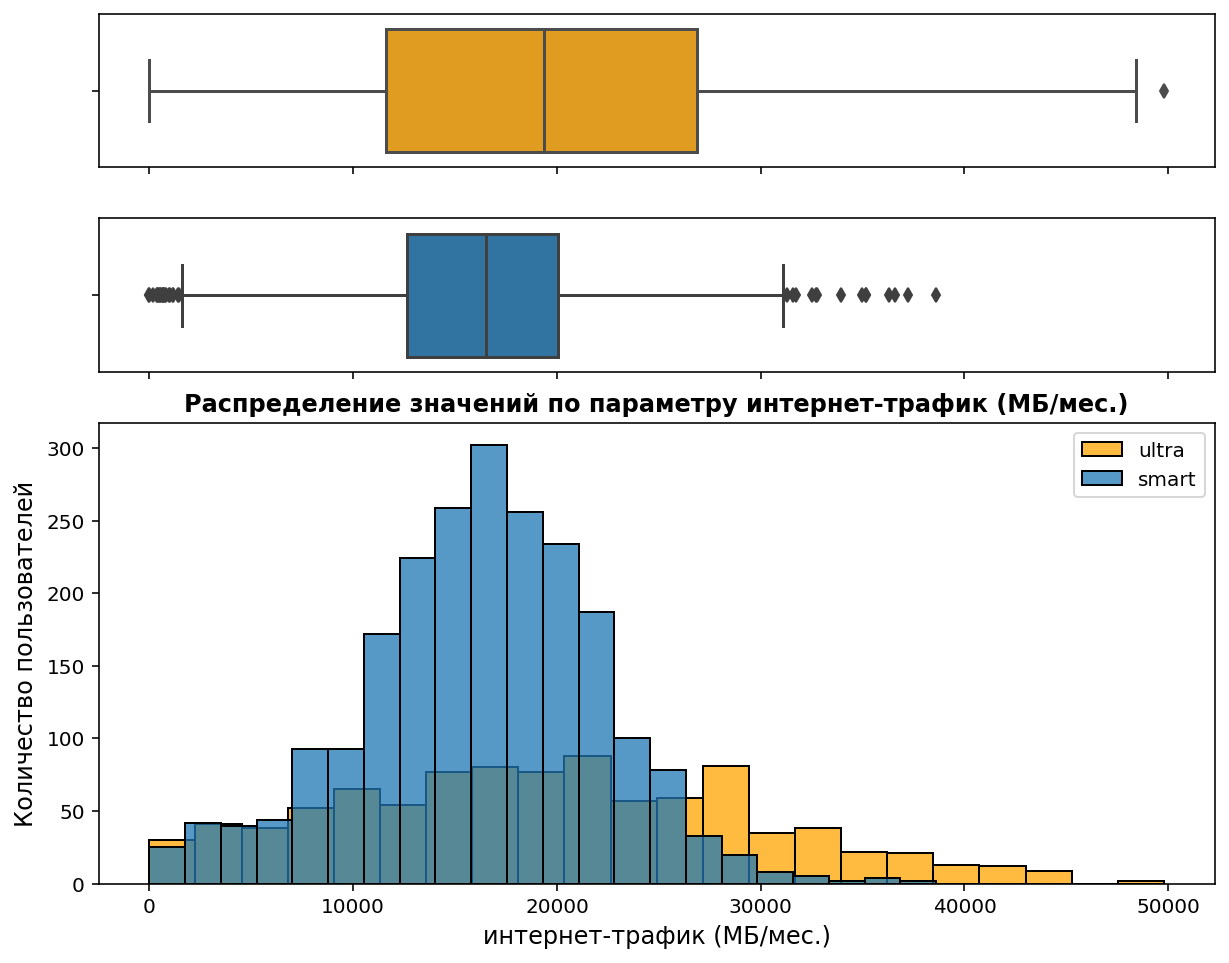

Среднее значение параметра интернет-трафик (МБ/мес.):
тариф "Ультра" : 19480.54
тариф "Смарт" : 16230.17
_______________________________________________________________________
Значение дисперсии параметра интернет-трафик (МБ/мес.):
тариф "Ультра" : 102737911.08
тариф "Смарт" : 34613960.71
_______________________________________________________________________
Значение стандартного отклонения параметра интернет-трафик (МБ/мес.):
тариф "Ультра" : 10135.97
тариф "Смарт" : 5883.36
_______________________________________________________________________


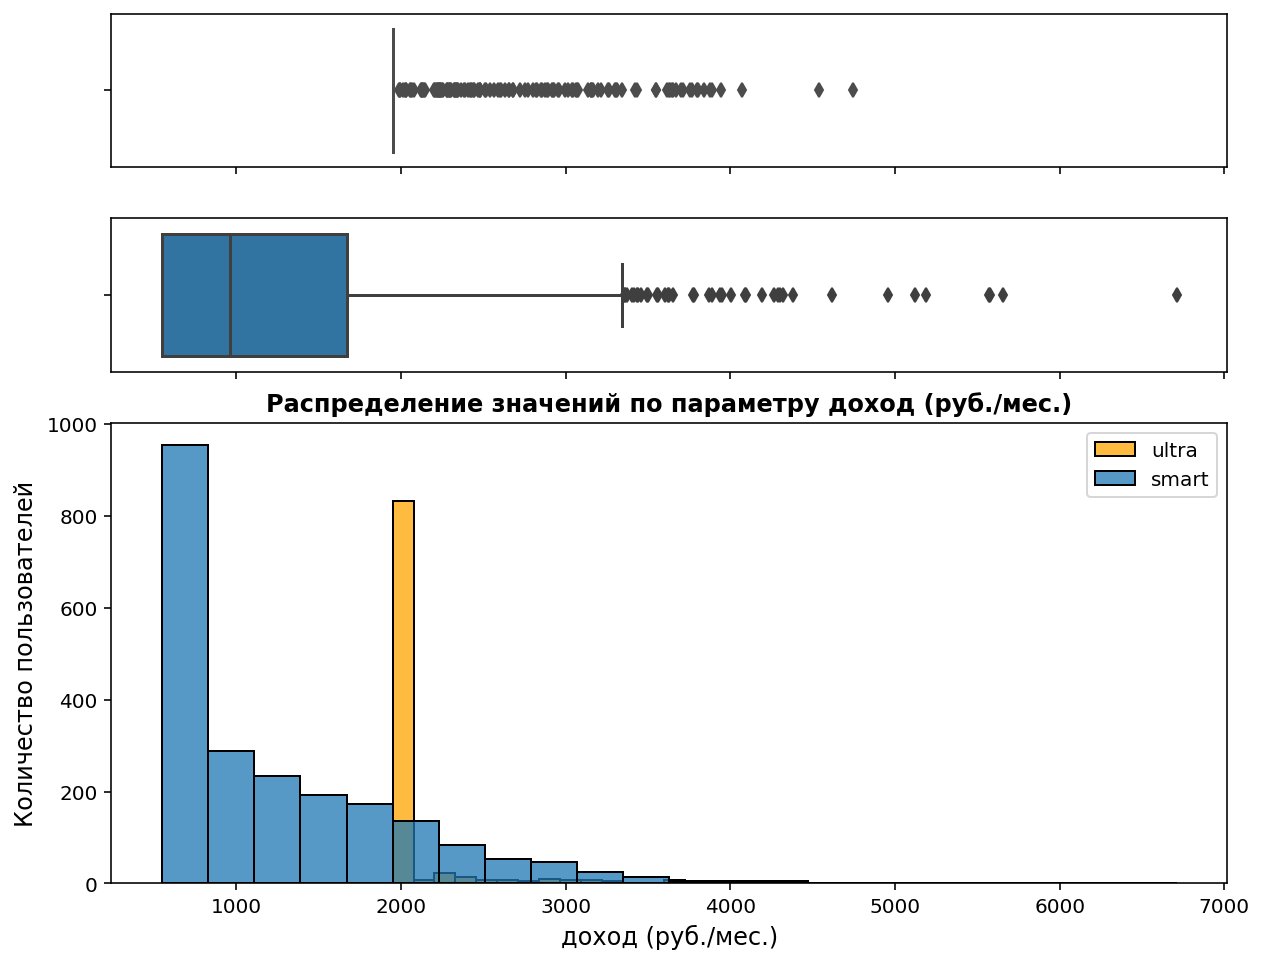

Среднее значение параметра доход (руб./мес.):
тариф "Ультра" : 2061.47
тариф "Смарт" : 1234.29
_______________________________________________________________________
Значение дисперсии параметра доход (руб./мес.):
тариф "Ультра" : 129213.24
тариф "Смарт" : 621581.7
_______________________________________________________________________
Значение стандартного отклонения параметра доход (руб./мес.):
тариф "Ультра" : 359.46
тариф "Смарт" : 788.4
_______________________________________________________________________


In [23]:
def creating_hist(feature, description):
    
    f, (ax_box0, ax_box1, ax_hist) = plt.subplots(3, sharex=True, 
                                                  gridspec_kw={"height_ratios": (.25, .25, .75)}, 
                                                  figsize=(10,8))    

    sns.boxplot(ultra[feature], ax=ax_box0, color='orange')
    sns.boxplot(smart[feature], ax=ax_box1)
    ax_box0.set(xlabel='')
    ax_box1.set(xlabel='')
        
    sns.histplot(data=ultra, x=feature, color='orange', bins=22,  label='Ultra')
    sns.histplot(data=smart, x=feature, bins=22, label='Smart')
    plt.legend(['ultra', 'smart'])
    
    plt.title(f'Распределение значений по параметру {description}',
              fontdict={'fontsize': 12, 'fontweight':'semibold', 'verticalalignment': 'baseline'})
        
    plt.xlabel(description, fontdict={'fontsize': 12}), 
    plt.ylabel('Количество пользователей', fontdict={'fontsize': 12})
    
    plt.show()
    print(f'Среднее значение параметра {description}:')
    print(f'тариф "Ультра" : {round(ultra[feature].mean(), 2)}')
    print(f'тариф "Смарт" : {round(smart[feature].mean(), 2)}')
    print('_______________________________________________________________________')
    print(f'Значение дисперсии параметра {description}:')
    print(f'тариф "Ультра" : {round(np.var(ultra[feature], ddof=1), 2)}')
    print(f'тариф "Смарт" : {round(np.var(smart[feature], ddof=1), 2)}')
    print('_______________________________________________________________________')
    print(f'Значение стандартного отклонения параметра {description}:')
    print(f'тариф "Ультра" : {round(np.std(ultra[feature], ddof=1), 2)}')
    print(f'тариф "Смарт" : {round(np.std(smart[feature], ddof=1), 2)}')
    print('_______________________________________________________________________')
        
features = {'total_duration':'длительность звонков (мин./мес.)', 
            'messages_amount':'количество сообщений (шт./мес.)',
            'mb_amount':'интернет-трафик (МБ/мес.)',
            'income': 'доход (руб./мес.)'}
    
for key, values in features.items():        
    creating_hist(key, values)

<em>Построенные графики и произведенные расчеты показывают следующее:</em>

- Тарифный план "Ультра":
распределение значений по параметрам длительность звонков и объем интернет-трафика тарифа "Ультра", стремится к нормальному без значительно выраженных пиков, имеет некоторую скошенность вправо;
распределение значений по тарифному плану "Ультра" имеет более широкий диапазон по сравнению с тарифным планом "Смарт", что показывают не только графики, но более чем в 2 раза большим значениями дисперсии и стандартного отклонения. 

- Тарифный план "Смарт":
распределение значений по параметрам длительность звонков и объем интернет-трафика тарифа "Смарт", стремится к нормальному, имеет некоторую скошенность влево;
распределение значений по количеству сообщений и выручке нессиметрично, имеют вид распределения Пуассона;
параметры тарифа "Смарт" принимают более высокие значения по сравнению с тарифом "Ультра", имеют явно выраженные пики, которые приходятся на размеры параметров, включенные в тарифный план.

**Выводы:** Наблюдение за параметрами тарифа "Смарт" показывает, что большинство из них принимают более высокие значения по сравнению с тарифом "Ультра". При этом диапазон, на котором появляются значения, более широкий по тарифу "Ультра". 

Значительному количеству пользователей тарифа "Смарт" не хватает бесплатных минут и интернет-трафика, включенных в тариф (среднее значение и медианна, близки к лимиту). Пользователи тарифа "Ультра" в основном достаточно количества минут и мегабайт, включенных в тарифный план.

Медианное значение параметра "Доход в месяц" по тарифному плану "Ультра", больше чем по тарифному плану "Смарт", но по тарифному плану "Смарт" наблюдается почти в 2 раза больший разброс. Межквартильный размаз по доходам по по тарифному плану "Смарт" также значительно выше, что свидетельствует, что пользователи не ограничиваются установленными тарифным планом лимитами по количеству бесплатных минут и мегабайт интернет-трафика. Это позволяет сделать вывод о том, что тарифный план с меньшей абонентской платой и меньшим количеством бесплатных может быть более привлекательнее для пользователей, но и позволяет получать значительно больше дохода сверх установленной абонентской платы.

## <a id='hypothesis-testing'><span style="color:black">5. Проверка гипотез.</span></a>

### <a id='revenue-difference-UltravsSmart'><span style="color:black">Проверяем гипотезу о различии средней выручки пользователей по тарифам "Ультра" и "Смарт".</span></a>

Нулевая гипотеза - средняя выручка по тарифам "Ультра" и "Смарт" не различается.
Альтернативная гипотеза - средняя выручка по тарифам "Ультра" и "Смарт" различается.

Для проверки гипотезы применим двухвыборочный критерий Стьюдента, основанный на предположении, что выборки получены из генеральной совокупностей, имеющих приближенно нормальное распраделение. Для реализации используем метод scipy.stats.ttest_ind библиотеки scipy. 

In [24]:
alpha = 0.05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(ultra['income'], smart['income'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4081556659852518e-184
Отвергаем нулевую гипотезу


Исходя из полученных результатов есть основания отвергнуть нулевую гипотезу в пользу альтернативной.


### <a id='revenue-difference-Moscowvsregions'><span style="color:black">Проверяем гипотезу о различии средней выручки пользователей из Москвы от выручки пользователей из других регионов.</span></a>

Нулевая гипотеза - средняя выручка пользователей из Москвы и пользователей из регионов не различается. Альтернативная гипотеза - средняя выручка пользователей из Москвы и пользователей из регионов различается.

In [25]:
alpha = 0.05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(summary_table[summary_table['city'] == 'Москва']['income'], summary_table[summary_table['city'] != 'Москва']['income'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.393324227019597
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что хотя средняя выручка пользователей из Москвы и средняя выручка пользователей из других регионов неодинакова, с вероятностью в почти 39% такое различие можно получить случайно. Нет оснований отвергнуть нулевую гипотезу в пользу альтернативыи.

## <a id='conclusions'><span style="color:black">6. Выводы.</span></a>

- Наблюдение за параметрами тарифа "Смарт" показывает, что большинство из них принимают более высокие значения по сравнению с тарифом "Ультра". При этом диапазон, на котором появляются значения, более широкий по тарифу "Ультра". 

- Значительному количеству пользователей тарифа "Смарт" не хватает бесплатных минут и интернет-трафика, включенных в тариф (среднее значение и медианна, близки к лимиту). Пользователи тарифа "Ультра" в основном достаточно количества минут и мегабайт, включенных в тарифный план.

- Медианное значение параметра "Доход в месяц" по тарифному плану "Ультра", больше чем по тарифному плану "Смарт", но по тарифному плану "Смарт" наблюдается почти в 2 раза больший разброс. Межквартильный размаз по доходам по по тарифному плану "Смарт" также значительно выше, что свидетельствует, что пользователи не ограничиваются установленными тарифным планом лимитами по количеству бесплатных минут и мегабайт интернет-трафика. Это позволяет сделать вывод о том, что тарифный план с меньшей абонентской платой и меньшим количеством бесплатных может быть более привлекательнее для пользователей, но и позволяет получать значительно больше дохода сверх установленной абонентской платы.
 
- Исходя из полученных результатов проверки гипотезы есть основания отвергнуть нулевую гипотезу о том, что средняя выручка по тарифам "Ультра" и "Смарт" одинаковая.

- Полученное значение p-value говорит о том, что хотя средняя выручка пользователей из Москвы и средняя выручка пользователей из других регионов неодинакова, с вероятностью в почти 39% такое различие можно получить случайно. Нет оснований отвергнуть нулевую гипотезу в пользу альтернативыи.